## Particle within radius or overlap calculations

In [42]:
#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist

#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("darkgrid")
import figurefirst

#misc
import time
np.set_printoptions(suppress=True)

In [43]:
dir_save = '../../data/Sprints/AN/'
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/Forest/Sprint01'
df = pd.read_hdf(dir+'/Sprint01Interpolated.h5')

In [8]:
df = df.drop(columns=['sync_time',
                      'distance_from_source',
                      'nearest_from_streakline', 'relative_motion', 'mock'
                      ])

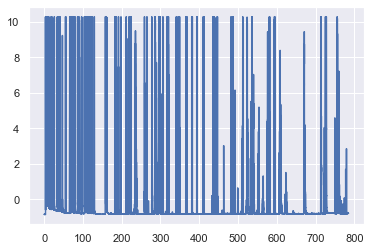

In [53]:
plt.plot(df.time,df.odor)

In [48]:
df.reset_index(inplace=True, drop=True) 

In [50]:
dt=df.master_time[1]-df.master_time[0]


time = []
time.append(0)
for i in range(1,len(df)):
    time.append(time[i-1]+dt)
    
df['time'] = time

In [45]:
pi = np.pi/180
x = np.abs(df.S2*np.sin(((df.D+13)*pi)))
y = np.abs(df.S2*np.cos(((df.D+13)*pi)))

x = x*np.sign(df.U)
y = y*np.sign(df.V)

df['corrected_u'] = x
df['corrected_v'] = y


In [10]:
dt=df.master_time[1]-df.master_time[0]

### Calculate Expected encounters

In [52]:
df.drop(df.loc[(df['time'] > 785)].index,inplace=True) 

In [54]:
# df.insert(1,'sync_time',sync_time)

# storing the odor location in a numpy array to avoid reading pandas
source = np.array([[0,0]])
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 

distance_from_source = np.array([cdist(odor_position,source)]).flatten()
df['distance_from_source'] = distance_from_source

### Relative Motion, and Distance Calculation

In [57]:
def relative_components(streakline_slope,sensor_dir,wind_dir,wind_speed,sensor_speed):
   
    ## perpendicular component
    wind_perpendicular_comp = np.sin(wrapped_angular_diff(streakline_slope,wind_dir))*wind_speed
    sensor_perpendicular_comp = np.sin(wrapped_angular_diff(streakline_slope,sensor_dir))*sensor_speed
    perp.append(wind_perpendicular_comp-sensor_perpendicular_comp)
    
    ## parallel component
    wind_parallel_comp = np.cos(wrapped_angular_diff(streakline_slope,wind_dir))*wind_speed
    sensor_parallel_comp = np.cos(wrapped_angular_diff(streakline_slope,sensor_dir))*sensor_speed
    paral.append(wind_parallel_comp-sensor_parallel_comp)
    

In [58]:
def wrapped_angular_diff(a, b):
    return np.arctan2(np.sin(a-b), np.cos(a-b))

def tangent_slope_direction(slope, x): 
    if (x >= 0):
        return slope
    else:
        if (slope > 0):
            return(3.14159265359 - slope)            
        else:
            return(-3.14159265359-(slope))
        
def relative_magnitude_calculation(i):
    wind_speed_magnitude = np.linalg.norm([df.corrected_u[i],df.corrected_v[i]])
    sensor_speed_magnitude = np.linalg.norm([df.gps_linear_x[i],df.gps_linear_y[i]])
    return wind_speed_magnitude, sensor_speed_magnitude

In [59]:
def relative_direction_calculation(streakline, pos, i):
    ## get the tangent from the nearest point
    if(pos == 0):
        x = streakline[pos:(pos+2),0]
        y = streakline[pos:(pos+2),1]
    else:
        x = streakline[(pos-1):(pos+2),0]
        y = streakline[(pos-1):(pos+2),1]
    slope_streakline,intercept_streakline=np.polyfit(x,y,1)
    
    streakline_slope=tangent_slope_direction(np.arctan(slope_streakline),streakline[pos,0] )
    
    ## find direction - source location
    sensor_dir = np.arctan2(df.gps_linear_y[i],df.gps_linear_x[i])
    wind_dir = np.arctan2(df.corrected_v[i],df.corrected_u[i])
    wind_speed, sensor_speed = relative_magnitude_calculation(i)
    
    relative_components(streakline_slope,sensor_dir,wind_dir,wind_speed,sensor_speed)    

In [60]:
def compute_distance(streakline, odor_position,i):
    source = np.array([[0,0]])
    radius = np.arange(start = 6000, stop = 0, step = -1)**0.5*0.01
    streakline = np.concatenate((streakline,source))
    distance = cdist(odor_position,streakline).flatten()   # cdist compares distance for all the points in both arrays
    nearest_from_streakline.append(np.min(distance))
    pos = np.where(distance == np.amin(distance))
    relative_direction_calculation(streakline, pos[0][0],i)
    

In [61]:
def find_streakline():
    eastwest = [np.sum(df.corrected_u[j:])*dt for j in range(0,len(df))]
    northsouth = [np.sum(df.corrected_v[j:])*dt for j in range(0,len(df))]
    return eastwest,northsouth

In [63]:
eastwest,northsouth = find_streakline()

In [136]:
# st = pd.read_hdf(dir+'/Main/WindyStreaklineCorrected.h5')
# eastwest = st.eastwest
# northsouth= st.northsouth

In [143]:
# for i in range(len(eastwest)-1, -1, -1):
#     odor_pos = [odor_position[i]] 
#     eastwest = np.resize(np.array([eastwest-df.corrected_u[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
#     with open('EW2.csv','a') as fd:
#         writer = csv.writer(fd)
#         writer.writerow(eastwest)

In [64]:
len(df)

157139

In [65]:
perp = []
paral = []
nearest_from_streakline = []
# distance_along_streakline = []
odor_presence=[]

for i in range(len(eastwest)-1, 100000, -1):
    odor_pos = [odor_position[i]] 
    eastwest = np.resize(np.array([eastwest-df.corrected_u[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-df.corrected_v[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T   
    radius = np.arange(start = 6000, stop = 0, step = -1)**0.5*0.01
    compute_distance(wind_pos,odor_pos,i)
    distance = cdist(odor_pos,wind_pos).flatten()
    x = np.any(distance<=radius)             # generates a boolean values 
    if x==True:
        odor_presence.append(1)
    else:
        odor_presence.append(0)

In [67]:

for i in range(len(eastwest)-1, 6000, -1):
    odor_pos = [odor_position[i]] 
    eastwest = np.resize(np.array([eastwest-df.corrected_u[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-df.corrected_v[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T   
    radius = np.arange(start = 6000, stop = 0, step = -1)**0.5*0.01
    compute_distance(wind_pos,odor_pos,i)
    distance = cdist(odor_pos,wind_pos).flatten()
    x = np.any(distance<=radius)             # generates a boolean values 
    if x==True:
        odor_presence.append(1)
    else:
        odor_presence.append(0)

In [68]:
#for the section when only the length of the elements is equal to the window value
for i in range((len(eastwest))-1, -1, -1):
    
    odor_pos = [odor_position[i]]  
    if(i == 0):
        radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
        distance = cdist(odor_pos,wind_pos).flatten()
        paral.append(0)
        perp.append(0)
        nearest_from_streakline.append(np.min(distance))
        odor_presence.append(0)
        
    else:
        eastwest = np.resize(np.array([eastwest-df.corrected_u[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
        northsouth = np.resize(np.array([northsouth-df.corrected_v[i]*dt]),(1,i)).flatten()
        wind_pos = np.vstack([eastwest,northsouth]).T   
        compute_distance(wind_pos,odor_pos,i)
        distance = cdist(odor_pos,wind_pos).flatten()
        radius = np.arange(start = i, stop = 0, step = -1)**0.5*0.01
#         nearest_from_streakline.append(np.min(distance))
        x = np.any(distance<=radius)             # generates a boolean values 
        if x==True:
            odor_presence.append(1)
        else:
            odor_presence.append(0)

In [69]:
## flip containers because above iteration is done in reverse order

# distance_along_streakline = np.array(np.flip(distance_along_streakline)) 
nearest_from_streakline = np.array(np.flip(nearest_from_streakline)) 

df['odorsim'] = odor_presence[::-1]

## storing in the dataframe 
# df['distance_along_streakline'] =  distance_along_streakline
df['nearest_from_streakline'] = nearest_from_streakline
df['relative_parallel_comp']=paral[::-1]
df['relative_perpendicular_comp']=perp[::-1]

In [70]:
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/Forest/Sprint01/'
df.to_hdf(dir+'Sprint01.h5', key='df', mode='w')

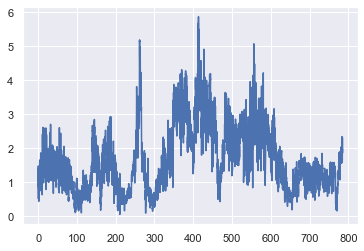

In [77]:
plt.plot(df.time,df.S2)

#### Extract Continuous Streakline

In [11]:
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/HighRes/'
df = pd.read_hdf(dir+'/NotWindy/NotWindyIF.h5')

In [12]:
angles = np.arange(45,95,5)
for x in range(len(angles)):
    time_res=2002*5 ## 50 seconds for highres 
    range_points = []
    start_angle=df.D[0]
    range_points.append(0)
    i = 0

    while i < (len(df)):
        diff = np.abs(df.D[i] - start_angle)
        if diff >= angles[x]:
            range_points.append(i)
            start_angle=df.D[i+time_res]
            i+=time_res
        else:
            i+=1
            continue

    cs=pd.DataFrame()
    j = 0
    while j < (len(range_points)):
    #     print(i)
        if(j < len(range_points)-1):
            cs = cs.append(df[range_points[j]:range_points[j+1]])        
        else:
            cs = cs.append(df[range_points[j]:])
        j+=2
    cs.reset_index(inplace=True, drop=True) 

    dt=df.time[1]-df.time[0]
    time = []
    time.append(0)
    for i in range(1,len(cs)):
        time.append(time[i-1]+dt)

    cs = cs.drop(columns=['time'])
    cs['time']=time
    cs.to_hdf(dir+'ContinuousNotWindy'+str(angles[x])+'.h5', key='cs', mode='w')

In [71]:
q1 = 'odor>4'
df1= df.query(q1)
# cs1 = cs.query(q1)

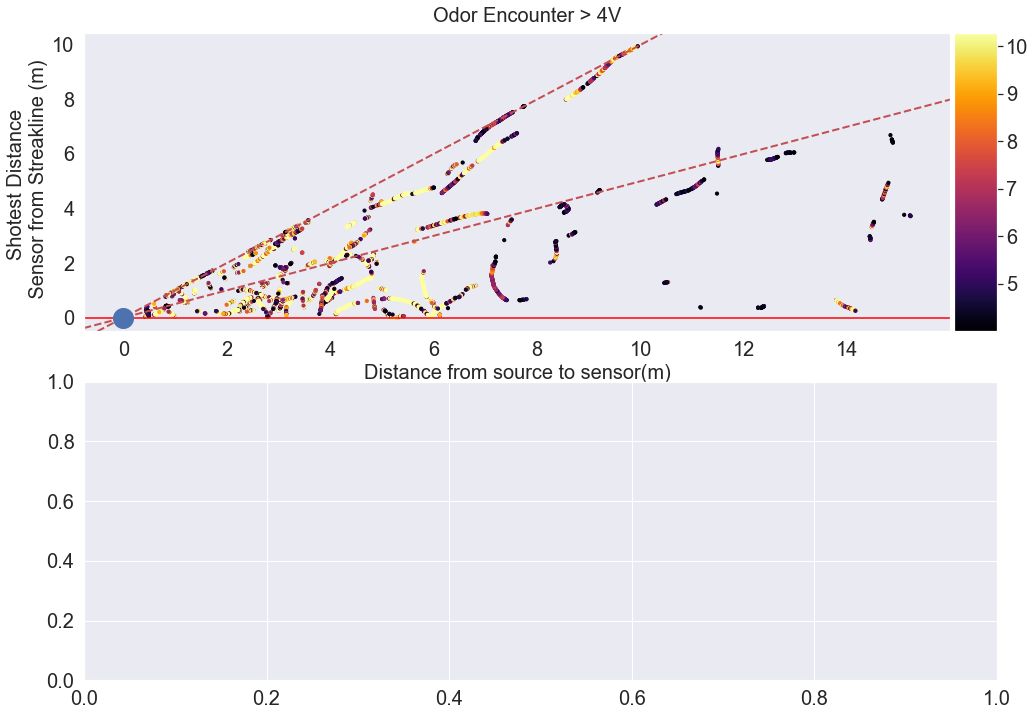

In [73]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(14,10))
f.suptitle('Odor Encounter > 4V')
ax1.axline((0, 0), slope=1.0, linestyle='dashed', linewidth=2, color='r')
ax1.axline((0, 0), slope=0.5, linestyle='dashed', linewidth=2, color='r')
ax1.axhline(0, color = 'red')
ax1.grid(False)
ax1.plot(0,0,'o', markersize = 20)
var = ax1.scatter(df1.distance_from_source, df1.nearest_from_streakline, cmap = 'inferno', 
                  c = df1.odor, label ='Odor_Not_Detected', s = 10)
ax1.set_xlabel('Distance from source to sensor(m)')
ax1.set_ylabel('Shotest Distance \n Sensor from Streakline (m)')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'vertical')


# ax2.axline((0, 0), slope=1.0, linestyle='dashed', linewidth=2, color='r')
# ax2.axline((0, 0), slope=0.5, linestyle='dashed', linewidth=2, color='r')
# ax2.axhline(0, color = 'red')
# ax2.grid(False)
# ax2.plot(0,0,'o', markersize = 20)

# var2 = ax2.scatter(cs1.distance_from_source, cs1.nearest_from_streakline_, cmap = 'inferno', 
#                   c = cs1.odor, s = 10)

# ax2.set_xlabel('Distance from source to sensor(m)')
# ax2.set_ylabel('Shotest Distance \n Sensor from Streakline (m)')
# # ax2.set_xlim ([-2,45]) 
# # ax2.set_ylim([-2,35])
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# f.colorbar(var2, cax=cax, orientation = 'vertical')

f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f, 20)
# f.savefig('../../Figure/distance_plots_notwindy.jpeg', dpi=1200) 

In [38]:
cs.to_hdf(dir+'ContinuousNotWindy.h5', key='cs', mode='w')